# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
! pip install torch torchvision torchsummary

    100% |████████████████████████████████| 591.8MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6219a000 @  0x7fe654f292a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 18.8MB/s 
    100% |████████████████████████████████| 2.0MB 5.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.4MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [6]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [7]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

Get all annotations & images paths

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

class imageDataset(Dataset):
    def __init__(self, data_basenames, channels = 3, height = 224, width = 224, transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if img.shape[0] == 1:  # change graysclae images to RGB
            img = torch.cat((img,img,img),0)      
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 16

# 80% train, 20% test
index_cut =  int(len(images)*0.8)
train_dataset = imageDataset(images[:index_cut])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = imageDataset(images[index_cut:])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

# Model start

## 1. CNN architectures



### 1.1 Single CNN architecture

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*111*111, 16*111)
        self.fc2 = nn.Linear(16*111, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = one_layer_cnn().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

one_layer_cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=197136, out_features=1776, bias=True)
  (fc2): Linear(in_features=1776, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]               0
         MaxPool2d-4         [-1, 16, 111, 111]               0
            Linear-5                 [-1, 1776]     350,115,312
            Linear-6                   [-1, 14]          24,878
Total params: 350,140,670
Trainable params: 350,140,670
Non-trainab

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [0]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))

In [0]:
treshold = 0.5
epoch = 10

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.000001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()

train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]


for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
        prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
        delta_loss = abs(val_loss[-1] - train_loss[-1])

Train Epoch: 1 [0/16000 0%]	Loss: 0.694478
Train Epoch: 1 [1600/16000 10%]	Loss: 0.225105
Train Epoch: 1 [3200/16000 20%]	Loss: 0.276353
Train Epoch: 1 [4800/16000 30%]	Loss: 0.253154
Train Epoch: 1 [6400/16000 40%]	Loss: 0.147454
Train Epoch: 1 [8000/16000 50%]	Loss: 0.173057
Train Epoch: 1 [9600/16000 60%]	Loss: 0.160469
Train Epoch: 1 [11200/16000 70%]	Loss: 0.259119
Train Epoch: 1 [12800/16000 80%]	Loss: 0.174156
Train Epoch: 1 [14400/16000 90%]	Loss: 0.171694
Validation set: Average loss: 0.2066, Accuracy: 92.78%, Precision: 42.53%, Recall: 5.74%
		F1 score : 10.12%

Train Epoch: 2 [0/16000 0%]	Loss: 0.191228
Train Epoch: 2 [1600/16000 10%]	Loss: 0.243373
Train Epoch: 2 [3200/16000 20%]	Loss: 0.108537
Train Epoch: 2 [4800/16000 30%]	Loss: 0.268760
Train Epoch: 2 [6400/16000 40%]	Loss: 0.195342
Train Epoch: 2 [8000/16000 50%]	Loss: 0.279117
Train Epoch: 2 [9600/16000 60%]	Loss: 0.170338
Train Epoch: 2 [11200/16000 70%]	Loss: 0.171292
Train Epoch: 2 [12800/16000 80%]	Loss: 0.151107


### 1.2 Simple cnn 2

In [128]:
class simple_cnn2(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn2,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.fc1 = nn.Linear(5*5*128, 128)
        self.fc2 = nn.Linear(128, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
      
model = simple_cnn2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

simple_cnn2(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 54, 54]          23,296
       BatchNorm2d-2           [-1, 64, 54, 54]             128
              ReLU-3           [-1, 64, 54, 54]  

In [129]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn2_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.697739
Train Epoch: 1 [1600/16000 10%]	Loss: 0.200957
Train Epoch: 1 [3200/16000 20%]	Loss: 0.185075
Train Epoch: 1 [4800/16000 30%]	Loss: 0.222508
Train Epoch: 1 [6400/16000 40%]	Loss: 0.251575
Train Epoch: 1 [8000/16000 50%]	Loss: 0.287641
Train Epoch: 1 [9600/16000 60%]	Loss: 0.187543
Train Epoch: 1 [11200/16000 70%]	Loss: 0.186691
Train Epoch: 1 [12800/16000 80%]	Loss: 0.152598
Train Epoch: 1 [14400/16000 90%]	Loss: 0.200864
Validation set: Average loss: 0.1903, Accuracy: 91.05%, Precision: 38.88%, Recall: 44.64%
		F1 score : 41.56%

Train Epoch: 2 [0/16000 0%]	Loss: 0.116632
Train Epoch: 2 [1600/16000 10%]	Loss: 0.195112
Train Epoch: 2 [3200/16000 20%]	Loss: 0.105548
Train Epoch: 2 [4800/16000 30%]	Loss: 0.138620
Train Epoch: 2 [6400/16000 40%]	Loss: 0.238428
Train Epoch: 2 [8000/16000 50%]	Loss: 0.252632
Train Epoch: 2 [9600/16000 60%]	Loss: 0.152694
Train Epoch: 2 [11200/16000 70%]	Loss: 0.133450
Train Epoch: 2 [12800/16000 80%]	Loss: 0.162424

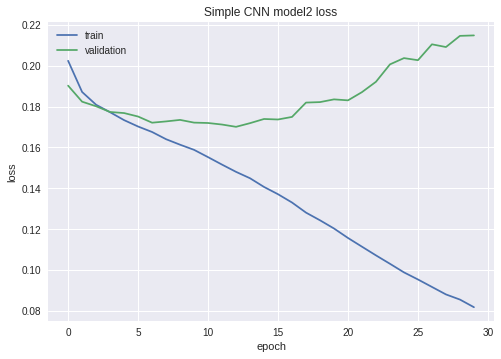

In [131]:
plt.title("Simple CNN model2 loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

looks still overfit

#### 1.2.1 with dropout

In [139]:
class simple_cnn2_drop(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn2_drop,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5*5*128, 128)
        self.fc2 = nn.Linear(128, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropout(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out
      
model = simple_cnn2_drop().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

simple_cnn2_drop(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 54, 54]          23,296
       BatchNorm2d-2           [-1, 64, 54, 54]             128
              Re

In [133]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 20

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.00001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn2_drop_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.734386
Train Epoch: 1 [1600/16000 10%]	Loss: 0.400717
Train Epoch: 1 [3200/16000 20%]	Loss: 0.251499
Train Epoch: 1 [4800/16000 30%]	Loss: 0.253158
Train Epoch: 1 [6400/16000 40%]	Loss: 0.194982
Train Epoch: 1 [8000/16000 50%]	Loss: 0.182945
Train Epoch: 1 [9600/16000 60%]	Loss: 0.225766
Train Epoch: 1 [11200/16000 70%]	Loss: 0.273282
Train Epoch: 1 [12800/16000 80%]	Loss: 0.216732
Train Epoch: 1 [14400/16000 90%]	Loss: 0.174309
Validation set: Average loss: 0.2092, Accuracy: 91.33%, Precision: 35.17%, Recall: 24.48%
		F1 score : 28.87%

Train Epoch: 2 [0/16000 0%]	Loss: 0.156967
Train Epoch: 2 [1600/16000 10%]	Loss: 0.170781
Train Epoch: 2 [3200/16000 20%]	Loss: 0.244647
Train Epoch: 2 [4800/16000 30%]	Loss: 0.167825
Train Epoch: 2 [6400/16000 40%]	Loss: 0.200741
Train Epoch: 2 [8000/16000 50%]	Loss: 0.187942
Train Epoch: 2 [9600/16000 60%]	Loss: 0.205391
Train Epoch: 2 [11200/16000 70%]	Loss: 0.176218
Train Epoch: 2 [12800/16000 80%]	Loss: 0.222907

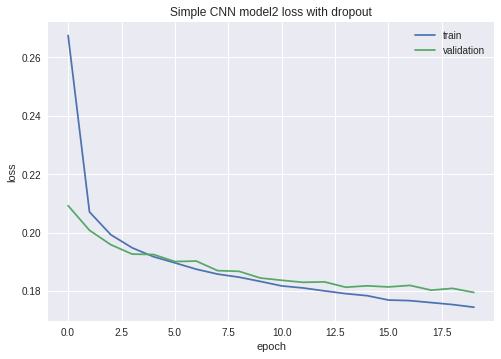

In [134]:
plt.title("Simple CNN model2 loss with dropout")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [140]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 20

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_simcnn2_drop2_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.699267
Train Epoch: 1 [1600/16000 10%]	Loss: 0.147568
Train Epoch: 1 [3200/16000 20%]	Loss: 0.236901
Train Epoch: 1 [4800/16000 30%]	Loss: 0.148070
Train Epoch: 1 [6400/16000 40%]	Loss: 0.191657
Train Epoch: 1 [8000/16000 50%]	Loss: 0.182377
Train Epoch: 1 [9600/16000 60%]	Loss: 0.170859
Train Epoch: 1 [11200/16000 70%]	Loss: 0.202445
Train Epoch: 1 [12800/16000 80%]	Loss: 0.234823
Train Epoch: 1 [14400/16000 90%]	Loss: 0.210743
Validation set: Average loss: 0.1893, Accuracy: 91.78%, Precision: 40.95%, Recall: 35.61%
		F1 score : 38.10%

Train Epoch: 2 [0/16000 0%]	Loss: 0.204171
Train Epoch: 2 [1600/16000 10%]	Loss: 0.206055
Train Epoch: 2 [3200/16000 20%]	Loss: 0.209324
Train Epoch: 2 [4800/16000 30%]	Loss: 0.230996
Train Epoch: 2 [6400/16000 40%]	Loss: 0.219722
Train Epoch: 2 [8000/16000 50%]	Loss: 0.149637
Train Epoch: 2 [9600/16000 60%]	Loss: 0.222880
Train Epoch: 2 [11200/16000 70%]	Loss: 0.166373
Train Epoch: 2 [12800/16000 80%]	Loss: 0.215509

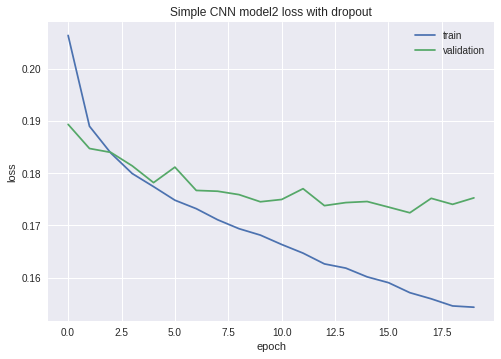

In [141]:
plt.title("Simple CNN model2 loss with dropout")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### 1.3 Simple CNN 3

In [95]:
class simple_cnn3(nn.Module):
    def __init__(self, nclass = 14):
        super(simple_cnn3,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 11,padding = 0,stride = 4),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 5,padding = 0,stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(5*5*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.dropout(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out
      
model = simple_cnn3().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

simple_cnn3(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5)
  (fc1): Linear(in_features=800, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 54, 54]           5,824
       BatchNorm2d-2           [-1, 16, 54, 54]              32
              ReLU-3           [-1, 16, 54, 54]               0
         MaxPool2d-4  

In [77]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])

Train Epoch: 1 [0/16000 0%]	Loss: 0.869107
Train Epoch: 1 [1600/16000 10%]	Loss: 0.245959
Train Epoch: 1 [3200/16000 20%]	Loss: 0.238010
Train Epoch: 1 [4800/16000 30%]	Loss: 0.223196
Train Epoch: 1 [6400/16000 40%]	Loss: 0.209303
Train Epoch: 1 [8000/16000 50%]	Loss: 0.221439
Train Epoch: 1 [9600/16000 60%]	Loss: 0.198705
Train Epoch: 1 [11200/16000 70%]	Loss: 0.189071
Train Epoch: 1 [12800/16000 80%]	Loss: 0.201746
Train Epoch: 1 [14400/16000 90%]	Loss: 0.193226
Validation set: Average loss: 0.2021, Accuracy: 91.96%, Precision: 40.33%, Recall: 25.56%
		F1 score : 31.29%

Train Epoch: 2 [0/16000 0%]	Loss: 0.195274
Train Epoch: 2 [1600/16000 10%]	Loss: 0.171579
Train Epoch: 2 [3200/16000 20%]	Loss: 0.245128
Train Epoch: 2 [4800/16000 30%]	Loss: 0.256328
Train Epoch: 2 [6400/16000 40%]	Loss: 0.196690
Train Epoch: 2 [8000/16000 50%]	Loss: 0.193814
Train Epoch: 2 [9600/16000 60%]	Loss: 0.171590
Train Epoch: 2 [11200/16000 70%]	Loss: 0.242157
Train Epoch: 2 [12800/16000 80%]	Loss: 0.192006

### 2.1 Deep CNN

In [125]:
class deep_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(10, stride=3)
        )
        #self.fc1 = nn.Linear(4096, 20)
        self.lastlayer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(5*5*64, 14)
        )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        #out = self.conv4(out)
        out = out.view(out.size(0),-1)
        out = self.lastlayer(out)
        return out
model = deep_cnn().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

deep_cnn(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [126]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 30

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    torch.save(model.state_dict(), '/content/gdrive/My Drive/Image_project/model_deepcnno_epoch'+str(i)+'.pkl')
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])

Train Epoch: 1 [0/16000 0%]	Loss: 0.684552
Train Epoch: 1 [1600/16000 10%]	Loss: 0.237730
Train Epoch: 1 [3200/16000 20%]	Loss: 0.228479
Train Epoch: 1 [4800/16000 30%]	Loss: 0.231039
Train Epoch: 1 [6400/16000 40%]	Loss: 0.228270
Train Epoch: 1 [8000/16000 50%]	Loss: 0.201196
Train Epoch: 1 [9600/16000 60%]	Loss: 0.171441
Train Epoch: 1 [11200/16000 70%]	Loss: 0.251514
Train Epoch: 1 [12800/16000 80%]	Loss: 0.189196
Train Epoch: 1 [14400/16000 90%]	Loss: 0.201751
Validation set: Average loss: 0.1948, Accuracy: 91.82%, Precision: 40.43%, Recall: 30.91%
		F1 score : 35.04%

Train Epoch: 2 [0/16000 0%]	Loss: 0.199817
Train Epoch: 2 [1600/16000 10%]	Loss: 0.193014
Train Epoch: 2 [3200/16000 20%]	Loss: 0.190237
Train Epoch: 2 [4800/16000 30%]	Loss: 0.221923
Train Epoch: 2 [6400/16000 40%]	Loss: 0.201448
Train Epoch: 2 [8000/16000 50%]	Loss: 0.269272
Train Epoch: 2 [9600/16000 60%]	Loss: 0.191121
Train Epoch: 2 [11200/16000 70%]	Loss: 0.206648
Train Epoch: 2 [12800/16000 80%]	Loss: 0.231596

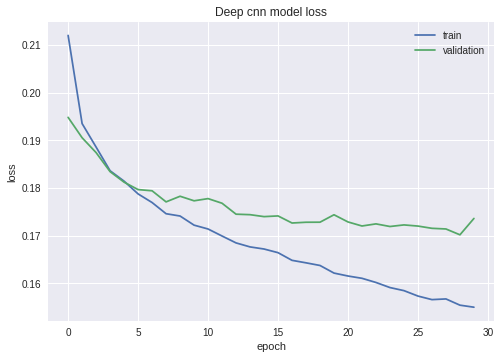

In [127]:
plt.title("Deep cnn model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

### 1.2 Simple CNN

In [0]:
class sim_cnn(nn.Module):
    def __init__(self, nclass = 14):
        super(sim_cnn_v1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(54*54*32, 54*32)
        self.fc2 = nn.Linear(54*32, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = F.relu(self.fc1(out))
        output = self.fc2(out)
        return output
        
model = sim_cnn_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 
print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

sim_cnn_v1(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=93312, out_features=1728, bias=True)
  (fc2): Linear(in_features=1728, out_features=14, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
       BatchNorm2d-2         [-1, 16, 222, 222]              32
              ReLU-3         [-1, 16, 222, 222]    

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [0]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.7087, Accuracy: 41.80%, Precision: 8.02%, Recall: 67.79%
		F1 score : 14.34%



In [0]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 3

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.688727
Train Epoch: 1 [1600/16000 10%]	Loss: 0.318948
Train Epoch: 1 [3200/16000 20%]	Loss: 0.271836
Train Epoch: 1 [4800/16000 30%]	Loss: 0.223150
Train Epoch: 1 [6400/16000 40%]	Loss: 0.258005
Train Epoch: 1 [8000/16000 50%]	Loss: 0.185912
Train Epoch: 1 [9600/16000 60%]	Loss: 0.228175
Train Epoch: 1 [11200/16000 70%]	Loss: 0.188632
Train Epoch: 1 [12800/16000 80%]	Loss: 0.213337
Train Epoch: 1 [14400/16000 90%]	Loss: 0.170509
Validation set: Average loss: 0.1978, Accuracy: 92.37%, Precision: 42.59%, Recall: 19.42%
		F1 score : 26.68%

Train Epoch: 2 [0/16000 0%]	Loss: 0.277277
Train Epoch: 2 [1600/16000 10%]	Loss: 0.219200
Train Epoch: 2 [3200/16000 20%]	Loss: 0.170834
Train Epoch: 2 [4800/16000 30%]	Loss: 0.163191
Train Epoch: 2 [6400/16000 40%]	Loss: 0.155567
Train Epoch: 2 [8000/16000 50%]	Loss: 0.177203
Train Epoch: 2 [9600/16000 60%]	Loss: 0.205676
Train Epoch: 2 [11200/16000 70%]	Loss: 0.160049
Train Epoch: 2 [12800/16000 80%]	Loss: 0.199456

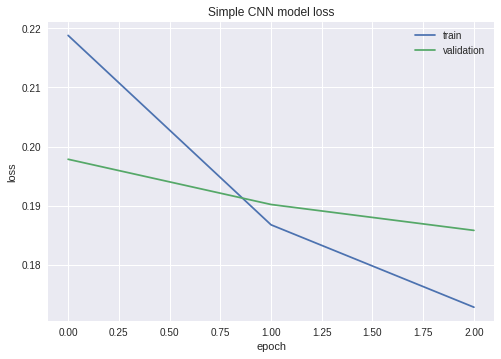

In [0]:
plt.title("Simple CNN model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [0]:
class one_layer_cnn(nn.Module):
    def __init__(self, nclass = 14):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size = 3,padding = 0,stride = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Linear(16*63*63, nclass)
        
    def forward(self,x):
        out = self.layer1(x)
        out = out.view(out.size(0),-1)
        output = self.fc1(out)
        return torch.sigmoid(output)

In [0]:
class deep_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=3)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        #self.fc1 = nn.Linear(4096, 20)
        
        
        #self.lastlayer = nn.Sequential(
         #   nn.Dropout(p=0.5),
          #  nn.Linear(5*5*64, 14)
        #)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.size(0),-1)
        #out = self.lastlayer(out)
        return out
model = deep_cnn().to(device)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
       BatchNorm2d-2         [-1, 16, 220, 220]              32
              ReLU-3         [-1, 16, 220, 220]               0
         MaxPool2d-4         [-1, 16, 110, 110]               0
            Conv2d-5         [-1, 32, 106, 106]          12,832
       BatchNorm2d-6         [-1, 32, 106, 106]              64
              ReLU-7         [-1, 32, 106, 106]               0
         MaxPool2d-8           [-1, 32, 53, 53]               0
            Conv2d-9           [-1, 64, 49, 49]          51,264
      BatchNorm2d-10           [-1, 64, 49, 49]             128
             ReLU-11           [-1, 64, 49, 49]               0
        MaxPool2d-12           [-1, 64, 15, 15]               0
           Conv2d-13          [-1, 128, 11, 11]         204,928
      BatchNorm2d-14          [-1, 128,

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [0]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.7064, Accuracy: 54.92%, Precision: 7.08%, Recall: 44.22%
		F1 score : 12.21%



In [0]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 3

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.667936
Train Epoch: 1 [1600/16000 10%]	Loss: 0.200935
Train Epoch: 1 [3200/16000 20%]	Loss: 0.248093
Train Epoch: 1 [4800/16000 30%]	Loss: 0.164543
Train Epoch: 1 [6400/16000 40%]	Loss: 0.257150
Train Epoch: 1 [8000/16000 50%]	Loss: 0.206457
Train Epoch: 1 [9600/16000 60%]	Loss: 0.216181
Train Epoch: 1 [11200/16000 70%]	Loss: 0.199187
Train Epoch: 1 [12800/16000 80%]	Loss: 0.196904
Train Epoch: 1 [14400/16000 90%]	Loss: 0.177506
Validation set: Average loss: 0.1966, Accuracy: 91.76%, Precision: 41.04%, Recall: 33.33%
		F1 score : 36.79%

Train Epoch: 2 [0/16000 0%]	Loss: 0.153161
Train Epoch: 2 [1600/16000 10%]	Loss: 0.213938
Train Epoch: 2 [3200/16000 20%]	Loss: 0.194608
Train Epoch: 2 [4800/16000 30%]	Loss: 0.172811
Train Epoch: 2 [6400/16000 40%]	Loss: 0.134571
Train Epoch: 2 [8000/16000 50%]	Loss: 0.209462
Train Epoch: 2 [9600/16000 60%]	Loss: 0.169818
Train Epoch: 2 [11200/16000 70%]	Loss: 0.193836
Train Epoch: 2 [12800/16000 80%]	Loss: 0.250889

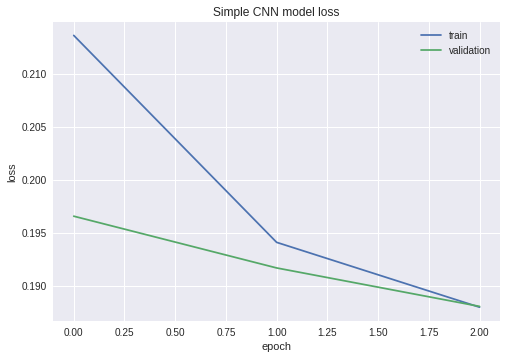

In [0]:
plt.title("Simple CNN model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [0]:
# TODO
class lstm(nn.Module):
    pass

Try several pretrained models - resnet18, VGG16

In [0]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
num_input = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_input, 14)
model = resnet18.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 

Train the model

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 10):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [0]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = output.data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.1212, Accuracy: 95.40%, Precision: 80.87%, Recall: 45.80%
		F1 score : 58.48%



In [0]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 3

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/14864 0%]	Loss: 0.097089
Train Epoch: 1 [160/14864 1%]	Loss: 0.078332
Train Epoch: 1 [320/14864 2%]	Loss: 0.098875
Train Epoch: 1 [480/14864 3%]	Loss: 0.077387
Train Epoch: 1 [640/14864 4%]	Loss: 0.076770
Train Epoch: 1 [800/14864 5%]	Loss: 0.076632
Train Epoch: 1 [960/14864 6%]	Loss: 0.058433
Train Epoch: 1 [1120/14864 8%]	Loss: 0.083280
Train Epoch: 1 [1280/14864 9%]	Loss: 0.124572
Train Epoch: 1 [1440/14864 10%]	Loss: 0.114254
Train Epoch: 1 [1600/14864 11%]	Loss: 0.135462
Train Epoch: 1 [1760/14864 12%]	Loss: 0.053206
Train Epoch: 1 [1920/14864 13%]	Loss: 0.069715
Train Epoch: 1 [2080/14864 14%]	Loss: 0.087980
Train Epoch: 1 [2240/14864 15%]	Loss: 0.092024
Train Epoch: 1 [2400/14864 16%]	Loss: 0.077988
Train Epoch: 1 [2560/14864 17%]	Loss: 0.109698
Train Epoch: 1 [2720/14864 18%]	Loss: 0.052550
Train Epoch: 1 [2880/14864 19%]	Loss: 0.090984
Train Epoch: 1 [3040/14864 20%]	Loss: 0.109693
Train Epoch: 1 [3200/14864 22%]	Loss: 0.131805
Train Epoch: 1 [3360/14864 23%]

In [0]:
# VGG16
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 14)])
vgg16.classifier = nn.Sequential(*features)

model = vgg16.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:10<00:00, 50894862.47it/s]


In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [0]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output.data.gt(treshold)) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.7127, Accuracy: 83.86%, Precision: 9.49%, Recall: 15.18%
		F1 score : 11.67%



In [0]:
%%time

treshold = 0.3
epoch = 1

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/14864 0%]	Loss: 0.137514
Train Epoch: 1 [160/14864 1%]	Loss: 0.140239
Train Epoch: 1 [320/14864 2%]	Loss: 0.127685
Train Epoch: 1 [480/14864 3%]	Loss: 0.174758
Train Epoch: 1 [640/14864 4%]	Loss: 0.105162
Train Epoch: 1 [800/14864 5%]	Loss: 0.107797
Train Epoch: 1 [960/14864 6%]	Loss: 0.188357
Train Epoch: 1 [1120/14864 8%]	Loss: 0.154210
Train Epoch: 1 [1280/14864 9%]	Loss: 0.123188
Train Epoch: 1 [1440/14864 10%]	Loss: 0.133201
Train Epoch: 1 [1600/14864 11%]	Loss: 0.125929
Train Epoch: 1 [1760/14864 12%]	Loss: 0.125949
Train Epoch: 1 [1920/14864 13%]	Loss: 0.154856
Train Epoch: 1 [2080/14864 14%]	Loss: 0.151181
Train Epoch: 1 [2240/14864 15%]	Loss: 0.071195
Train Epoch: 1 [2400/14864 16%]	Loss: 0.120647
Train Epoch: 1 [2560/14864 17%]	Loss: 0.137326
Train Epoch: 1 [2720/14864 18%]	Loss: 0.189465
Train Epoch: 1 [2880/14864 19%]	Loss: 0.116413
Train Epoch: 1 [3040/14864 20%]	Loss: 0.101466
Train Epoch: 1 [3200/14864 22%]	Loss: 0.154064
Train Epoch: 1 [3360/14864 23%]

KeyboardInterrupt: ignored

In [0]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.uint8)
Truth
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 

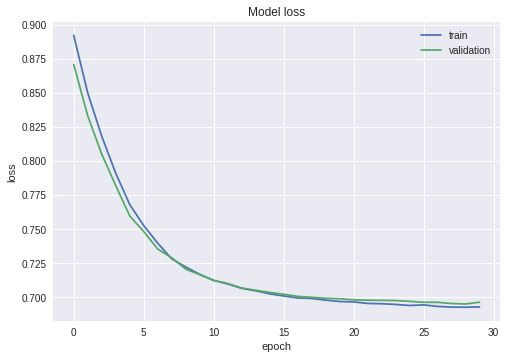

In [0]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [0]:
all_img_paths = sorted([img_path + current_img_name  for current_img_name  in listdir(img_path) ])
all_labels_paths = sorted([labels_path + current_label_name  for current_label_name  in listdir(labels_path) ])

In [0]:
all_img_nb = [all_img_paths[i].split("/")[-1].split(".")[0].split("im")[-1] for i in range(len(all_img_paths))]
all_labels_names = [all_labels_paths[i].split("/")[-1].split(".")[0] for i in range(len(all_labels_paths))]

LABELS PREPROCESSING 

ADD labelled Images

In [0]:
img_labels = {}
for current_label in range(len(all_labels_paths)):
    current_label_contents = pd.read_csv(all_labels_paths[current_label])
    current_label_img_nb = sorted(np.append(list(current_label_contents), current_label_contents.get_values() ).tolist())
    for current_img in current_label_img_nb:
        if( current_img not in img_labels.keys()):
            img_labels[current_img] = np.zeros(len(all_labels_names))
        img_labels[current_img][current_label] = 1
        

ADD unlabelled images

In [0]:
def unmatched_set(a, b):
    return [[a_i for a_i in a if a_i not in b], [b_i for b_i in b if b_i not in a]]

Get disjoined sets of unlabelled images and inexistent labelled images .

In [0]:
unmatched_set_images = unmatched_set( list(img_labels.keys()) , np.array(all_img_nb))

In [0]:
for current_unlab_img in unmatched_set_images[1]:
    img_labels[current_unlab_img] = np.zeros(len(all_labels_names))

IMAGES PREPROCESSING

There are 2 kinds of pictures :  
  - the first kind : The shapes equal to (128, 128, 3)
  - the second kind : The shapes equal to (128, 128)
  

In [0]:
img_shape = {}
for current_img_path in all_img_paths:
    current_img_vector =  plt.imread( current_img_path )
    
    #if (str(str(current_img_vector.shape)) == "(128, 128)"):
    #    print(current_img_vector.shape, current_img_path)
    #    unicolor_name = current_img_path
    #    unicolor = current_img_vector
    if(str(current_img_vector.shape) not in img_shape.keys()):
        img_shape[str(current_img_vector.shape)] = []
    img_shape[str(current_img_vector.shape)].append(current_img_path)

In [0]:
img_shape.keys()

dict_keys(['(128, 128, 3)', '(128, 128)'])

In [0]:
?plt.imread

RGB images

In [0]:
img_vector_3 = {}
#To process with all images, don't forget to remove "[:10]"
for current_img_path in img_shape["(128, 128, 3)"][:1024]:
    I =  plt.imread( current_img_path )
    modified_current_img_vector = np.array([I[:,:,0], I[:,:,1], I[:,:,2]])
    img_vector_3[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = modified_current_img_vector


Grey images

In [0]:
img_vector_1 = {}

for current_img_path in img_shape["(128, 128)"]:
    current_img_vector =  plt.imread( current_img_path )
    #Do we have to reshape to (128*128) or (1,128*128) ?
    img_vector_1[current_img_path.split("/")[-1].split(".")[0].split("im")[-1]] = np.reshape(current_img_vector, (1,128,128))


In [0]:
img_vector_1

{'10034': array([[[ 11,  15,  12, ...,  16,  14,  16],
         [ 11,  14,  12, ...,  16,  13,  14],
         [ 11,  14,  12, ...,  15,  13,  14],
         ...,
         [  6,  11,   8, ...,  11,   5,   4],
         [  6,   8,   9, ...,  38,  51,  67],
         [  7,   6,  10, ..., 105,  84,  72]]], dtype=uint8),
 '1005': array([[[ 72,  67, 129, ...,   7,   6,   6],
         [ 89,  71,  64, ...,   8,  16,  11],
         [ 70,  80, 108, ...,  23,  34,  24],
         ...,
         [ 36,  16,  11, ..., 122, 136,  75],
         [ 46,  34,  31, ..., 112, 156,  98],
         [ 69,  62,  53, ...,  80, 142, 119]]], dtype=uint8),
 '10064': array([[[ 8,  3,  3, ...,  1,  2,  3],
         [ 3,  4,  0, ...,  3,  5,  5],
         [ 0,  4,  4, ...,  1,  2,  1],
         ...,
         [ 2,  2,  4, ..., 35, 31, 31],
         [ 4,  4,  2, ..., 65, 54, 43],
         [ 1,  3,  3, ..., 29, 20,  3]]], dtype=uint8),
 '1007': array([[[  8,   9,   5, ...,  14,  10,  11],
         [  5,  13,  10, ...,  14,  13

In [0]:
nb_img_vector_3 = len(img_vector_3.keys())

Create train dataset and test dataset from 3 dimention images

In [0]:

batch_size = 64

img_names = rd.sample(list(img_vector_3.keys()), nb_img_vector_3)
train_img_name = img_names[ :int(nb_img_vector_3 * 0.8)]
test_img_name = img_names[ int(nb_img_vector_3 * 0.8):]


X_Train = torch.from_numpy(np.array([ [ img_vector_3[ train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(train_img_name)/batch_size))]))
y_Train = torch.from_numpy(np.array([ [ img_labels[   train_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(train_img_name)/batch_size))]))

X_Test = torch.from_numpy(np.array([ [ img_vector_3[ test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ] for id_name in range(int(len(test_img_name)/batch_size))]))
y_Test = torch.from_numpy(np.array([ [ img_labels[   test_img_name[id_name*batch_size + id_batch]]  for id_batch in range(batch_size) ]for id_name in range(int(len(test_img_name)/batch_size))]))

X_Train = X_Train.type('torch.FloatTensor')
y_Train = y_Train.type('torch.FloatTensor')
X_Test = X_Test.type('torch.FloatTensor')
y_Test = y_Test.type('torch.FloatTensor')


In [0]:
print(X_Train.shape)
print(y_Train.shape)
print(X_Test.shape)
print(y_Test.shape)

torch.Size([12, 64, 3, 128, 128])
torch.Size([12, 64, 14])
torch.Size([3, 64, 3, 128, 128])
torch.Size([3, 64, 14])


In [0]:
X_Test.shape

torch.Size([3, 64, 3, 128, 128])

In [0]:
X_Test[0].shape

torch.Size([64, 3, 128, 128])

In [0]:
train_loader = zip(X_Train, y_Train)
test_loader = zip(X_Test, y_Test)

In [0]:
for  batch_idx, (data, target) in enumerate(train_loader) :
    print(data.shape)
    print(target.shape)
    print(batch_idx)

torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
0
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
1
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
2
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
3
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
4
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
5
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
6
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
7
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
8
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
9
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
10
torch.Size([64, 3, 128, 128])
torch.Size([64, 14])
11


random NN

In [0]:

class Net(nn.Module):
    def __init__(self ):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.mp = nn.MaxPool2d(2)
        self.do = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm1d(num_features=18000)
        self.fc1 = nn.Linear(18000, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fcout = nn.Linear(120, 14)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.do(x)
        x =  F.relu(self.bn1(x))
        x = F.relu((self.fc1(x)))
        x = F.relu((self.fc2(x)))
        x = F.log_softmax(self.fcout(x))
        return x
    
    
model = Net( )#.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) 
criterion = nn.CrossEntropyLoss()  
#criterion = nn.BCELoss
print(model)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (do): Dropout(p=0.5)
  (bn1): BatchNorm1d(18000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=18000, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (fcout): Linear(in_features=120, out_features=14, bias=True)
)


Forward

In [0]:
model.forward(X_Train[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.6356, -2.7033, -2.5611, -2.5944, -2.6164, -2.6539, -2.7160, -2.7650,
         -2.7305, -2.5867, -2.5827, -2.6628, -2.6888, -2.4873],
        [-2.6502, -2.7235, -2.5829, -2.5481, -2.6687, -2.6629, -2.6615, -2.7280,
         -2.6754, -2.6017, -2.6234, -2.6153, -2.6993, -2.5299],
        [-2.7033, -2.6695, -2.5515, -2.5933, -2.6888, -2.6657, -2.6602, -2.7050,
         -2.6784, -2.5806, -2.6111, -2.6807, -2.6973, -2.4900],
        [-2.6996, -2.6896, -2.5973, -2.5882, -2.6826, -2.6190, -2.6479, -2.7416,
         -2.6802, -2.6345, -2.5997, -2.6418, -2.6687, -2.4827],
        [-2.7269, -2.6826, -2.6190, -2.5561, -2.6894, -2.6584, -2.6857, -2.7345,
         -2.6219, -2.5884, -2.6146, -2.6623, -2.6591, -2.4792],
        [-2.6674, -2.6558, -2.5560, -2.5894, -2.6797, -2.6573, -2.6639, -2.7473,
         -2.6979, -2.5855, -2.5922, -2.6472, -2.6773, -2.5509],
        [-2.6701, -2.6455, -2.5748, -2.6171, -2.6727, -2.6554, -2.7219, -2.6828,
         -2.6686, -2.5684, -2.5930, -2.6777, -2.6

In [0]:
def train(epoch,trainv, log_interval=100):
    # Set model to training mode
    model.train()
    train_loss = 0
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        #data = data.to(device)
        #target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data.type("torch.FloatTensor"))

        # Calculate loss
        loss = criterion(output, target)
        train_loss += loss.data.item()
        
        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    trainv.append( train_loss / float(len(train_loader)))

In [0]:
list(train_loader)

[]

In [0]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        #data = data.to(device)
        #target = target.to(device)
        
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [0]:
%%time
epochs = 2

lossv, accv, trainv = [], [], []
for epoch in range(1, epochs + 1):
    train(epoch, trainv)
    #validate(lossv, accv)

TypeError: ignored

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
np.savetxt('results.txt', y, fmt='%d')